<a href="https://colab.research.google.com/github/politeles/audio_classification/blob/main/ComparativaDeClasificadores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparativa de clasificadores de audio
En este cuaderno vamos a comparar dos clasificadores de audio, ambos usan el dataset VADS que contiene 9 clases imbalanceadas con golpes de arco de violín.

Un clasificador esta basado en Wav2Vec usando un modelo distilHubert. El otro clasificador parte de una red neuronal clásica que utiliza un espectrograma de mel para clasificar el sonido.

Para comparar los dos clasificadores, vamos a utilizar las siguientes medidas:
 - Matriz de confusión.
 - Accuracy, Precisión y Recall de cada clase.
 - Accuracy global.
 - F1
 - Tiempo para generar la predicción.

 ## Modelo Distilhubert para VADS
 Descargamos el modelo ya entrenado desde HuggingFace.

In [1]:
!pip install datasets[audio]

In [2]:
pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-956vr86y
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-956vr86y
  Resolved https://github.com/huggingface/transformers to commit 27a25bee4fcb865e8799ba026f1ea4455f2cca98
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import os
from google.colab import userdata
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

In [4]:
from transformers import pipeline

pipe = pipeline(
    "audio-classification", model="politeles/distilhubert-finetuned-gtzan"
)

config.json:   0%|          | 0.00/1.90k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/94.8M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

Device set to use cuda:0


In [5]:
from datasets import load_dataset

In [6]:
from datasets import Audio

In [7]:
vads = load_dataset("politeles/vads")

In [8]:
vads = vads.cast_column("audio", Audio(sampling_rate=16_000))

In [9]:
id2label_fn = vads["train"].features['technique'].int2str

In [10]:
label2id_fn = vads["train"].features['technique'].str2int

In [11]:
# Shuffle the dataset and select the first 100 samples
sampled_dataset = vads["train"].shuffle(seed=42).select(range(2500))

In [12]:
from tqdm.auto import tqdm
from transformers.pipelines.pt_utils import KeyDataset

In [13]:
result = []
for out in tqdm(pipe(KeyDataset(sampled_dataset, "audio"))):
    result.append(max(out, key=lambda x: x['score'])['label'])
    print(out)
result

  0%|          | 0/2500 [00:00<?, ?it/s]

[{'score': 0.9395599961280823, 'label': 'sulponticello'}, {'score': 0.022987384349107742, 'label': 'legato'}, {'score': 0.015933243557810783, 'label': 'doublestops'}, {'score': 0.007415464613586664, 'label': 'ricochet'}, {'score': 0.003245162544772029, 'label': 'chords'}, {'score': 0.002993666334077716, 'label': 'martele'}, {'score': 0.002959840465337038, 'label': 'pizz'}, {'score': 0.0025728552136570215, 'label': 'bariolage'}, {'score': 0.0023323548957705498, 'label': 'spicatto'}]
[{'score': 0.9778931736946106, 'label': 'pizz'}, {'score': 0.004301088862121105, 'label': 'chords'}, {'score': 0.004289162810891867, 'label': 'spicatto'}, {'score': 0.0035776207223534584, 'label': 'legato'}, {'score': 0.003324611112475395, 'label': 'bariolage'}, {'score': 0.001935883890837431, 'label': 'sulponticello'}, {'score': 0.0017487979494035244, 'label': 'martele'}, {'score': 0.00174372096080333, 'label': 'ricochet'}, {'score': 0.0011859694495797157, 'label': 'doublestops'}]
[{'score': 0.8801702857017

['sulponticello',
 'pizz',
 'sulponticello',
 'chords',
 'ricochet',
 'ricochet',
 'chords',
 'sulponticello',
 'pizz',
 'sulponticello',
 'sulponticello',
 'ricochet',
 'ricochet',
 'spicatto',
 'ricochet',
 'spicatto',
 'sulponticello',
 'bariolage',
 'martele',
 'martele',
 'legato',
 'ricochet',
 'legato',
 'martele',
 'spicatto',
 'ricochet',
 'doublestops',
 'ricochet',
 'spicatto',
 'sulponticello',
 'bariolage',
 'sulponticello',
 'sulponticello',
 'doublestops',
 'ricochet',
 'martele',
 'pizz',
 'bariolage',
 'ricochet',
 'martele',
 'legato',
 'doublestops',
 'pizz',
 'sulponticello',
 'pizz',
 'ricochet',
 'sulponticello',
 'sulponticello',
 'sulponticello',
 'sulponticello',
 'ricochet',
 'martele',
 'martele',
 'spicatto',
 'doublestops',
 'sulponticello',
 'spicatto',
 'doublestops',
 'pizz',
 'ricochet',
 'chords',
 'doublestops',
 'doublestops',
 'ricochet',
 'sulponticello',
 'doublestops',
 'sulponticello',
 'doublestops',
 'sulponticello',
 'spicatto',
 'spicatto',


In [14]:
from sklearn.preprocessing import label_binarize

In [15]:
# define a binary label for Y and for the y_score
Y_test = label_binarize(sampled_dataset['technique'], classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])

In [16]:
y_score_id = []

for i in range(len(result)):
  y_score_id.append(label2id_fn(result[i]))

In [17]:
y_score = label_binarize(y_score_id, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8])

In [18]:
from sklearn.metrics import average_precision_score, precision_recall_curve

In [19]:
n_classes = 9
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

In [20]:
from sklearn.metrics import PrecisionRecallDisplay

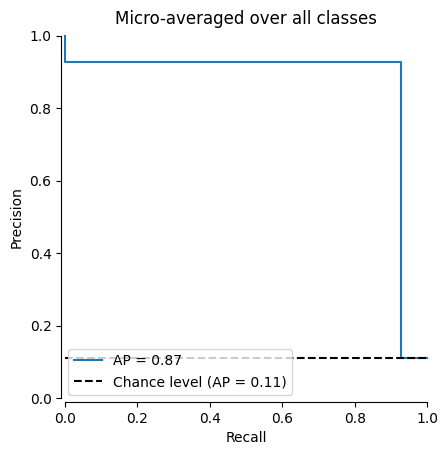

In [21]:
from collections import Counter

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
    prevalence_pos_label=Counter(Y_test.ravel())[1] / Y_test.size,
)
display.plot(plot_chance_level=True, despine=True)
_ = display.ax_.set_title("Micro-averaged over all classes")

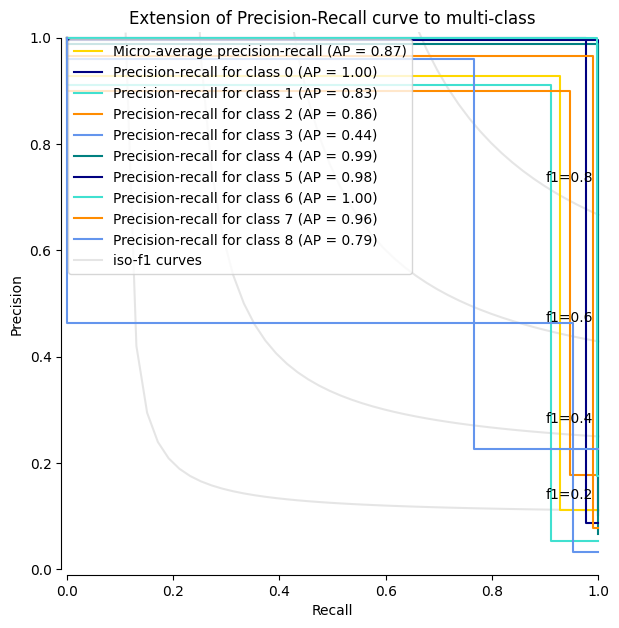

In [22]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(
        ax=ax, name=f"Precision-recall for class {i}", color=color, despine=True
    )

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

In [23]:
true_labels = [id2label_fn(label) for label in sampled_dataset['technique']]

In [24]:
from collections import Counter

def summarize_labels(labels):
    """Summarizes the labels array, providing the total number of elements and the count of each category.

    Args:
        labels (list): A list of labels.

    Returns:
        None (Prints the summary to the console)
    """
    total_elements = len(labels)
    category_counts = Counter(labels)

    print(f"Total elements: {total_elements}")
    print("Category counts:")
    for category, count in category_counts.items():
        print(f"- {category}: {count}")

# Example usage:
summarize_labels(true_labels)
summarize_labels(result)

Total elements: 2500
Category counts:
- sulponticello: 564
- pizz: 219
- chords: 134
- ricochet: 441
- doublestops: 445
- spicatto: 194
- bariolage: 254
- martele: 165
- legato: 84
Total elements: 2500
Category counts:
- sulponticello: 450
- pizz: 214
- chords: 134
- ricochet: 440
- spicatto: 199
- bariolage: 255
- martele: 167
- legato: 173
- doublestops: 468


In [70]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [71]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, result, labels=list(pipe.model.config.id2label.values()))

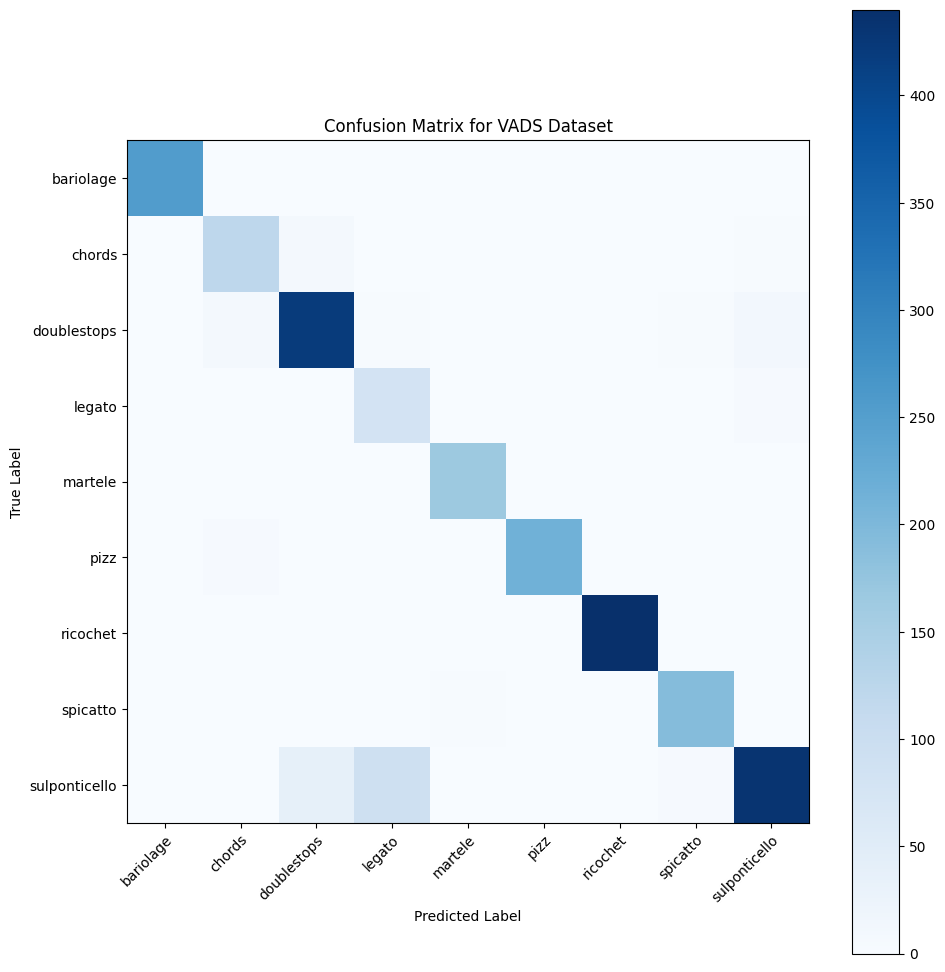

In [27]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Set labels, title, and ticks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=pipe.model.config.id2label.values(),
       yticklabels=pipe.model.config.id2label.values(),
       title="Confusion Matrix for VADS Dataset",
       ylabel="True Label",
       xlabel="Predicted Label")

# Rotate x-axis labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Display the plot
plt.tight_layout()
plt.show()

## Cargamos el modelo de red neuronal
Para este modelo vamos a calcular los mismos valores que para el anterior.

In [28]:
!pip install tensorflow_hub as hub

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [29]:
import tensorflow as tf
import tensorflow_hub as hub

In [30]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [67]:
def get_yamnnet_embeddings(audio):
     _, embeddings, _ = yamnet_model(audio)
     return embeddings

In [63]:
vads_yamnet = tf.keras.models.load_model("/data/vads_model.keras")

### Preparamos los datos
Calculamos los embeddings para el conjunto de datos del modelo.

In [57]:
from datasets import DatasetDict, Dataset

In [60]:
def preproces_sample(ds:Dataset):
  samples, labels = [], []
  for elem in tqdm(ds):
    audio_data = elem['audio']['array']
    scores, embeddings, spectrogram = yamnet_model(audio_data)

    # Check if embeddings is None or contains None values
    if embeddings is None or np.any(np.equal(embeddings, None)):
        print(f"Skipping sample with None embeddings: {elem}")  # Add this line to identify problematic samples
        continue  # Skip this sample and proceed to the next

    for feature in embeddings:
      samples.append(feature)
      labels.append(elem['technique'])
  samples = np.asarray(samples)
  labels = np.asarray(labels)
  return samples, labels

In [61]:
samples, labels = preproces_sample(sampled_dataset)

  0%|          | 0/2500 [00:00<?, ?it/s]

In [69]:
vads_yamnet(samples[0])

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input [0.         0.         0.02199275 ... 0.         0.         0.        ]. Expected shape (None, 1024), but input has incompatible shape (1024,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1024,), dtype=float32)
  • training=None
  • mask=None